<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"
alt="Rubin Observatory logo, a graphical representation of turning stars into data."> <br><br>
**Description:** DP1 ComCam Standard Bandpasse <br>
**Authors:** Eli Rykoff, Leanne Guy, <br>
**Last verified to run:** 2025-06-24 <br>
**LSST Science Pipelines version:** v29.1<br>
**Container size:** medium <br>

In [1]:
import matplotlib.pyplot as plt

from lsst.daf.butler import Butler
from lsst.utils.plotting import publication_plots
from lsst.utils.plotting import get_multiband_plot_colors, get_multiband_plot_symbols

In [2]:
! echo $IMAGE_DESCRIPTION
! eups list -s | grep lsst_distrib

Recommended
lsst_distrib          gc675d380bf+d086b35ba1 	current o_latest v29_1_1 v29_1_1_rc1 setup


In [3]:
# Set publication style
publication_plots.set_rubin_plotstyle()
colors = get_multiband_plot_colors()
bands = colors.keys() 
symbols = get_multiband_plot_symbols()

In [4]:
skymapName = 'lsst_cells_v1'
instrument="LSSTComCam"
collections=[
    'LSSTComCam/DP1/defaults',
    'LSSTComCam/DP1',
    'skymaps']
butler = Butler("/repo/dp1_prep", instrument="LSSTComCam", 
                collections=collections, 
                skymap=skymapName)
registry = butler.registry

In [5]:
# Find the right dataset type
dstype_regex = '*band*'
dsTypes = [datasetType for datasetType in registry.queryDatasetTypes(dstype_regex)]
dsTypes

[DatasetType('standard_passband', {band, instrument}, ArrowAstropy)]

In [6]:
# Get the throughputs for ComCam filters by band not 'physical_filter' 
# Conceptual passbands, not pieces of glass
throughputs = {}
for band in bands:
    std_bp = butler.get("standard_passband", band=band)
    throughputs[band] = std_bp

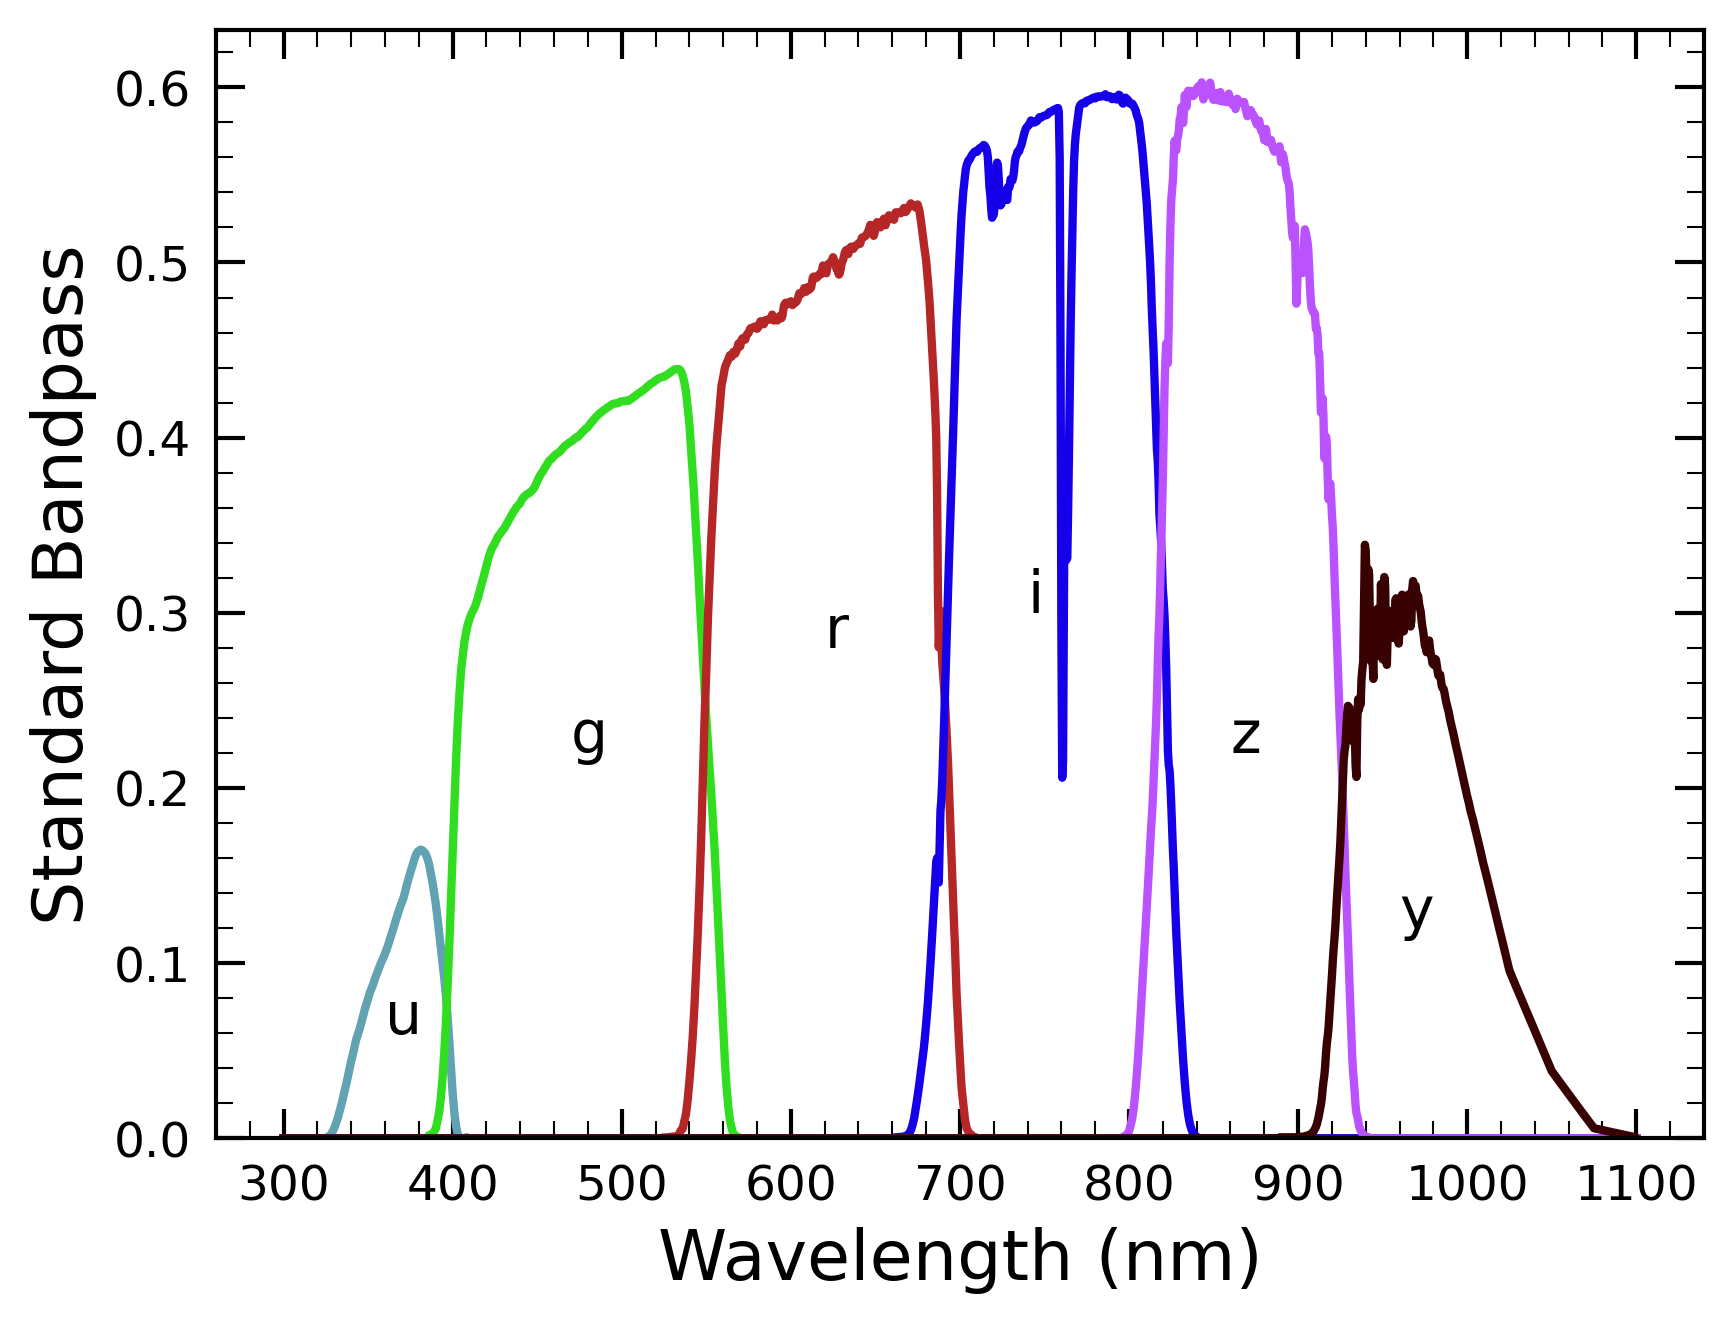

In [7]:
# Plot 
plt.figure()
for band, std_bp in throughputs.items():

    tpt = std_bp['throughput']/100
    plt.plot(std_bp['wavelength'], tpt,
             color = colors[band[0]],
             label=band)

# Force a y-axis zero 
plt.ylim(0)

# Add axis labels and title
plt.xlabel('Wavelength (nm)')  
plt.ylabel('Standard Bandpass')

# Annotate with band label
plt.text(360, 0.06, 'u')
plt.text(470, 0.22, 'g')
plt.text(620, 0.28, 'r')
plt.text(740, 0.30, 'i')
plt.text(860, 0.22, 'z')
plt.text(960, 0.12, 'y')

plt.savefig("../figures/dp1_comcam_std_bandpasses.pdf", 
            bbox_inches='tight', transparent=True, format='pdf')         

In [8]:
# Only close the figure after saving
plt.close()